In [27]:
from keras_vggface.vggface import VGGFace
from keras.layers import Dense,Flatten,Input
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Sequential

In [28]:
from keras.models import Model

base_model=VGGFace(input_shape=[224,224]+[3],weights='vggface',include_top=False)
for layers in base_model.layers:
    layers.trainable=False
x=Flatten()(base_model.output)
#x=Dense(10,activation='softmax')(x)
#x=Dense(128)(x)
    
vgg_model=Model(inputs=base_model.input,outputs=x)
vgg_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)      

In [29]:
images_dir='dataset'
import os
img_dir=os.listdir(images_dir)

In [30]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum((anchor - positive)**2, axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum((anchor - negative)**2, axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    ### END CODE HERE ###
    
    return loss

In [31]:
vgg_model.compile(optimizer='adam',loss=triplet_loss,metrics=['accuracy'])

In [32]:
import cv2
face_encodings=[]
i=-1
cls_labels=[]
for img in img_dir:
    i+=1
    for images in os.listdir(images_dir+'/'+img):
        try:
        
            img1=cv2.imread(images_dir+'/'+img+'/'+images)
        
            img1=cv2.resize(img1,(224,224))
            img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
            img1=img1/255
            img1=np.expand_dims(img1,axis=0)
            face_encoding=vgg_model.predict(img1)
            face_encodings.append(face_encoding)
            cls_labels.append(i)
        except IndexError as e:
            pass

In [8]:
#print(face_encodings)

In [48]:
from keras.models import Sequential
from keras.layers import Dense
model=Sequential()
model.add(Dense(5749,activation='softmax'))

In [49]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
X_train=np.array(face_encodings)
Y_train=np.array(cls_labels)

In [37]:
print(Y_train.shape)
print(X_train.shape)

(92619,)
(92619, 1, 25088)


In [38]:
X_train=X_train.reshape(92619,25088)


In [40]:
Y_train=Y_train.reshape(92619,1)

In [44]:
import pandas as pd
#X_train_df=X_train.reshape(X_train.shape[0]*X_train.shape[1])
#Y_train_df=Y_train.reshape(Y_train.shape[0]*Y_train.shape[1])
df=pd.DataFrame({'Encodings':[X_train],'Classification':[Y_train]})

In [45]:
df.to_csv('image_encodings.csv')

In [47]:
from keras.utils import to_categorical
Y_train_oh=to_categorical(Y_train)

In [53]:
model.fit(X_train,Y_train_oh,batch_size=32,epochs=5,shuffle=True)

Epoch 1/5
2895/2895 [==============================] - 3458s 1s/step - loss: 0.2764 - accuracy: 0.9484
Epoch 2/5
2895/2895 [==============================] - 3577s 1s/step - loss: 0.0391 - accuracy: 0.9950
Epoch 3/5
2895/2895 [==============================] - 3554s 1s/step - loss: 0.0146 - accuracy: 0.9983
Epoch 4/5
2895/2895 [==============================] - 3606s 1s/step - loss: 0.0083 - accuracy: 0.9987
Epoch 5/5
2895/2895 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.99 - 3390s 1s/step - loss: 0.0050 - accuracy: 0.9991


[[5.1807910e-15 1.0742894e-13 3.1108052e-18 ... 3.2827054e-20
  6.8347840e-19 9.9999928e-01]]
5748
Hi, Zydrunas Ilgauskas


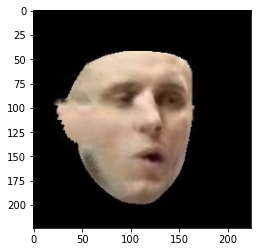

In [59]:
import sqlite3
import matplotlib.pyplot as plt
#print(X_train.shape)
img=cv2.imread('dataset/Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0001_1_-30.jpg')
face_enc=cv2.resize(img,(224,224))
face_enc=cv2.cvtColor(face_enc,cv2.COLOR_BGR2RGB)
#face_enc=face_enc.reshape(1,128)
#print(face_enc.shape[1])
plt.imshow(face_enc)
face_enc=face_enc/255
face_enc=np.expand_dims(face_enc,axis=0)
face_enc=vgg_model.predict(face_enc)
preds=model.predict(face_enc)
print(preds)
preds=np.argmax(preds,axis=1)[0]
print(preds)
conn = sqlite3.connect("face_db.db")
cur=conn.cursor()
cursor=cur.execute("SELECT f_name FROM faces where f_id="+str(preds+2))
for row in cursor:
    name=row[0]
name=name.replace('_',' ')
print("Hi, "+name)

In [60]:
model.save('final_model.h5')

In [61]:
np.savetxt('classes.csv',Y_train,header='classification')